# Stereo Rectification

Suppose we have four cameras `cam0`, ..., `cam3` capturing a chessboard on the floor as shown in the image below.  This notebook demonstrates

- how to rectifiy images between each pair of these cameras, and
- how to triangulate 3D points in WCS from
  - corresponding points found in the rectified images, and
  - a disparity map between the rectified images.

![overview](../data/mvs/overview.png)

## Synthetic data

This cell loads images and calibration parameters of the scene above.

- the chessboard is at $z=0$
- `cam0` is at $(0, 0, 8)$ and up=+Y, $(720, 480)$ resolution, $f=1200$ px (FoV $60^\circ$)
- `cam1` is at $(0.1, 2, 8)$ and up=+Y, $(600, 400)$ resolution, $f=833$ px (FoV $50^\circ$)
- `cam2` is at $(2, -0.1, 8)$ and up=-X, $(600, 400)$ resolution, $f=833$ px (FoV $50^\circ$)
- `cam3` is at $(-2, 0.1, 8)$ and up=-X, $(600, 400)$ resolution, $f=833$ px (FoV $50^\circ$)

The original blender script can also be found in [../data/mvs/](../data/mvs/).

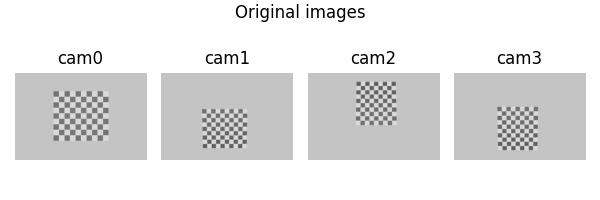

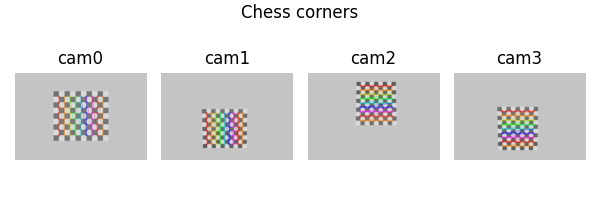

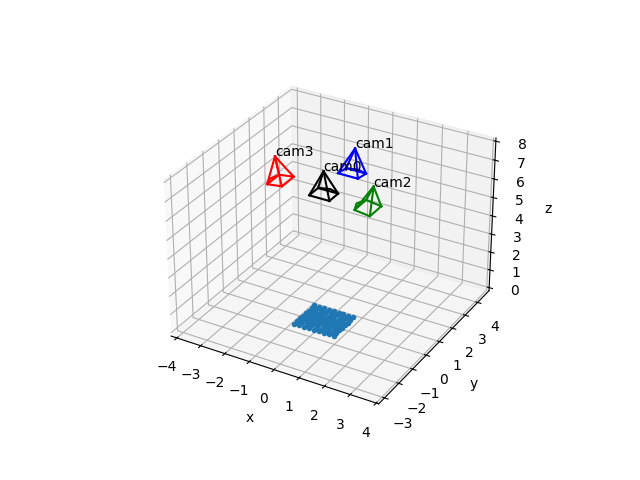

In [1]:
%matplotlib widget
import sys, os, cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
import pycalib

PREFIX = '../data/mvs/'

IMG = []
K = []
R_w2c = []
t_w2c = []
for i in range(4):
    img = cv2.imread(os.path.join(PREFIX, f'cam{i}.png'), cv2.IMREAD_COLOR)
    cam = json.load(open(os.path.join(PREFIX, f'cam{i}.json'), 'r'))
    IMG.append(img)
    K.append(cam['K'])
    R_w2c.append(cam['R'])
    t_w2c.append(cam['t'])
K = np.array(K)
R_w2c = np.array(R_w2c)
t_w2c = np.array(t_w2c)
P = []
for k, r, t in zip(K, R_w2c, t_w2c):
    rt = np.hstack([r, t.reshape((3,1))])
    P.append(k@rt)
P = np.array(P)

def show_imgs(imgs, labels=None, title=None):
    if labels is None:
        labels = [f'cam{i}' for i in range(len(imgs))]
    elif len(labels) < len(imgs):
        for i in range(len(labels), len(imgs)):
            labels.append(f'cam{i}')

    fig, ax = plt.subplots(1, len(imgs), figsize=(6,2), tight_layout=True)
    for i, (img, label) in enumerate(zip(imgs, labels)):
        ax[i].imshow(img[:,:,::-1])
        ax[i].set_title(label)
        ax[i].axis("off")
    if title is not None:
        fig.suptitle(title)
    plt.show()
    return

show_imgs(IMG, title='Original images')

# chess pattern detector
def findchess(img, pattern_size=(8, 9), draw_corners=True):
    assert len(img.shape) == 3
    assert img.shape[2] == 3

    retval, corners = cv2.findChessboardCorners(img, pattern_size)
    assert retval

    corners = cv2.cornerSubPix(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), corners, (5,5), (-1,-1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1))
    if draw_corners:
        img = cv2.drawChessboardCorners(img.copy(), pattern_size, corners, retval)
    else:
        img = None

    return corners.reshape((-1,2)), img

# detected corner positions
CORNERS_2D = []
tmp = []
for img in IMG:
    corners, img = findchess(img)
    CORNERS_2D.append(corners)
    tmp.append(img)
CORNERS_2D = np.array(CORNERS_2D)
show_imgs(tmp, title='Chess corners')

# triangulate
CORNERS_3D = pycalib.triangulate_Npts(CORNERS_2D, P)

# plot
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pycalib.plotCamera(ax, R_w2c[0], t_w2c[0], color="k", scale=0.4, is_w2c=True, label='cam0')
pycalib.plotCamera(ax, R_w2c[1], t_w2c[1], color="b", scale=0.4, is_w2c=True, label='cam1')
pycalib.plotCamera(ax, R_w2c[2], t_w2c[2], color="g", scale=0.4, is_w2c=True, label='cam2')
pycalib.plotCamera(ax, R_w2c[3], t_w2c[3], color="r", scale=0.4, is_w2c=True, label='cam3')
ax.plot(CORNERS_3D[:,0], CORNERS_3D[:,1], CORNERS_3D[:,2], ".")
pycalib.axisEqual3D(ax)
plt.show()

def show_overlay(img1r, img2r):
    plt.figure(figsize=(6,4))
    tmp = img1r.copy()
    tmp[:,:,1] = np.logical_and(img1r[:,:,0]>0, img2r[:,:,0]>0) * np.max(img1r)
    tmp[:,:,2] = img2r[:,:,2]
    plt.imshow(tmp[:,:,::-1])
    cursor = Cursor(plt.gca(), useblit=True, color="green", linewidth=1)
    plt.title("blue/yellow:camA, red/cyan:camB")
    plt.show()


## Project points

To double-check that the calibration parameters are consistent with OpenCV model, this cell projects some representative points on the floor to the camera images.

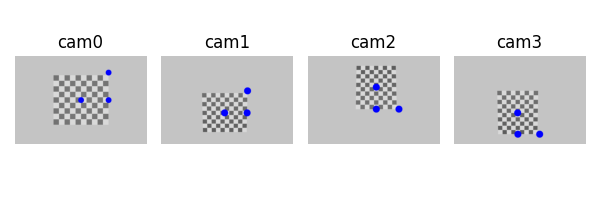

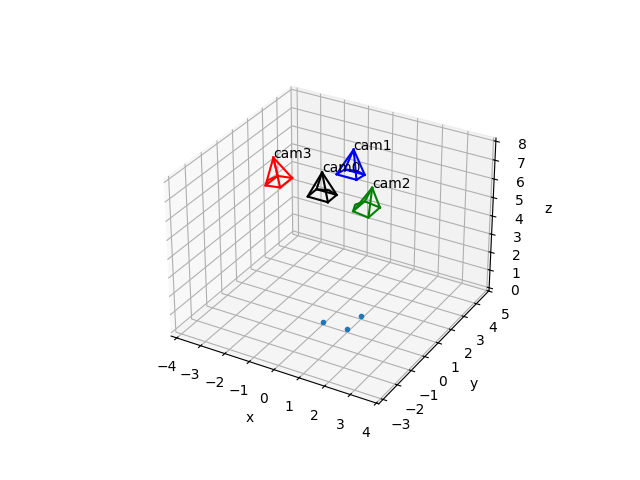

In [2]:
# (0,0), (1,0), (1,1)
X = np.array([[0,0,0], [1,0,0], [1,1,0]], dtype=np.float32).reshape((-1, 3))

imgs = []
for i in range(len(K)):
    x, _ = cv2.projectPoints(X, cv2.Rodrigues(R_w2c[i])[0], t_w2c[i], K[i], None)
    x = x.reshape((-1, 2))
    # c = R_w2c[i] @ (X.T) + t_w2c[i].reshape((3,1))
    # x = K[i] @ c
    # x = x / x[2,:]
    # x = x.T
    img = IMG[i].copy()
    for uv in x.astype(int):
        cv2.circle(img, (uv[0], uv[1]), 16, (255,0,0), -1)
    imgs.append(img)

show_imgs(imgs)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
pycalib.plotCamera(ax, R_w2c[0], t_w2c[0], color="k", scale=0.4, is_w2c=True, label='cam0')
pycalib.plotCamera(ax, R_w2c[1], t_w2c[1], color="b", scale=0.4, is_w2c=True, label='cam1')
pycalib.plotCamera(ax, R_w2c[2], t_w2c[2], color="g", scale=0.4, is_w2c=True, label='cam2')
pycalib.plotCamera(ax, R_w2c[3], t_w2c[3], color="r", scale=0.4, is_w2c=True, label='cam3')
ax.plot(X[:,0], X[:,1], X[:,2], ".")
pycalib.axisEqual3D(ax)
plt.show()


## Rectification

The goal of recitification is to make the epipolar lines parallel in the image, by projecting the epipoles, i.e., the intersections of the baseline and the image planes to infinity.

The fundamental idea of rectification by OpenCV is to apply a rotation for each camera so that their X-axes (or Y-axes) are oriented to the direction of the baseline.

The cell below applies the following steps (in [`pycalib.stereo.StereoPair`](../pycalib/stereo.py)) to demonstrate that we can obtain the 3D points in WCS using corresponding points / disparities in the rectified images.

1. Apply stereo rectification by [`cv2.stereoRectify()`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga617b1685d4059c6040827800e72ad2b6).
   - Modify the obtained parameters to magnify the rectified images (`scale` option).
2. Convert the original (unrectified) images to the rectified frames by [`cv2.remap()`](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#gab75ef31ce5cdfb5c44b6da5f3b908ea4).
3. Find corresponding points in the rectified images.
   - To simplify the correspondence search, this example uses the corners found by `cv2.findChessboardCorners()` as sparse corresponding points.
4. Triangulate 3D points in WCS from the corresponding points.
5. Triangulate 3D points in WCS from a depth-map converted from the corresponding points using [`cv2.reprojectImageTo3D()`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga1bc1152bd57d63bc524204f21fde6e02).

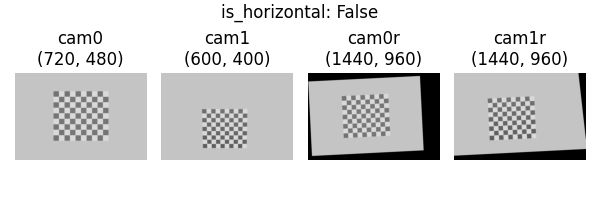

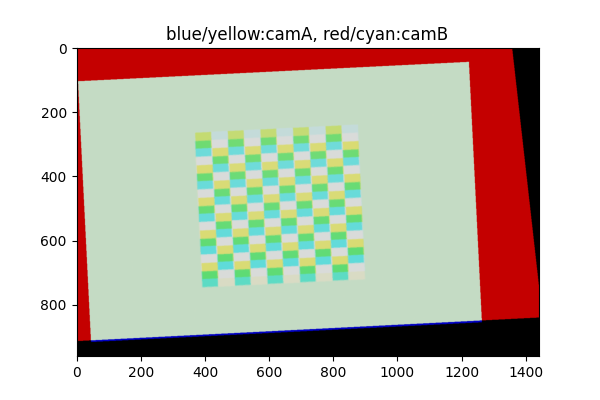

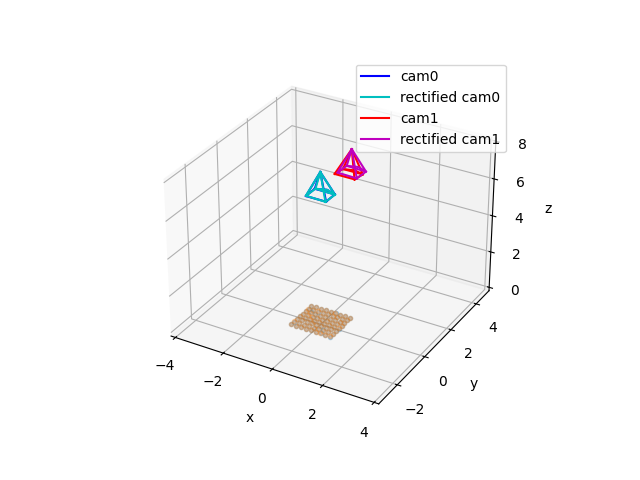

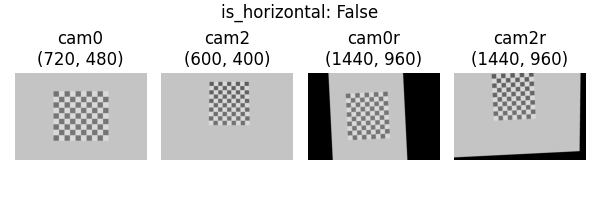

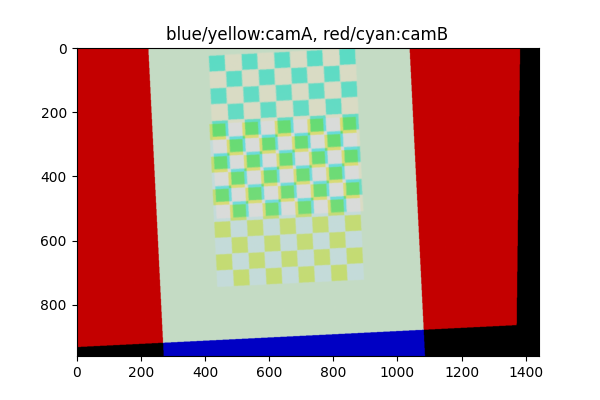

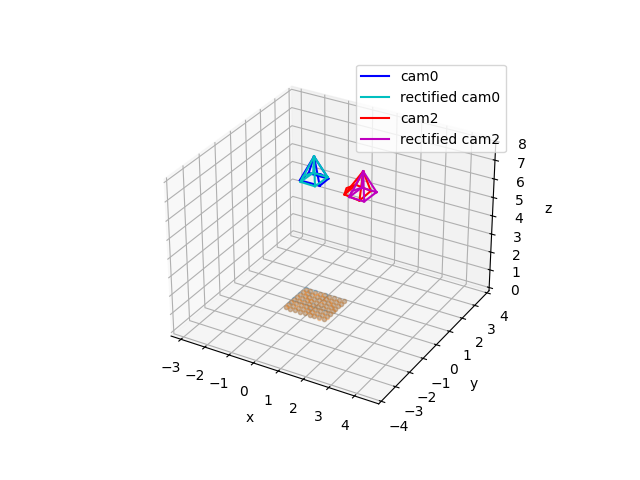

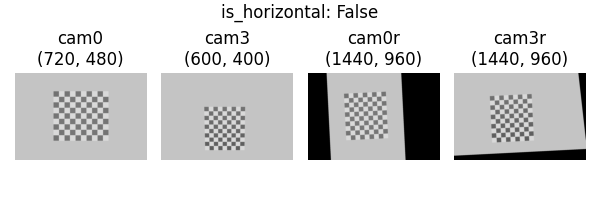

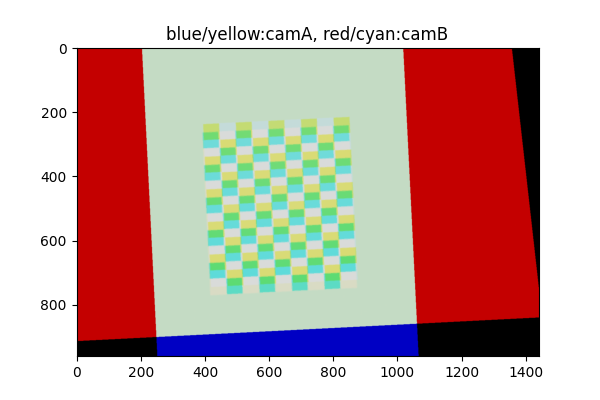

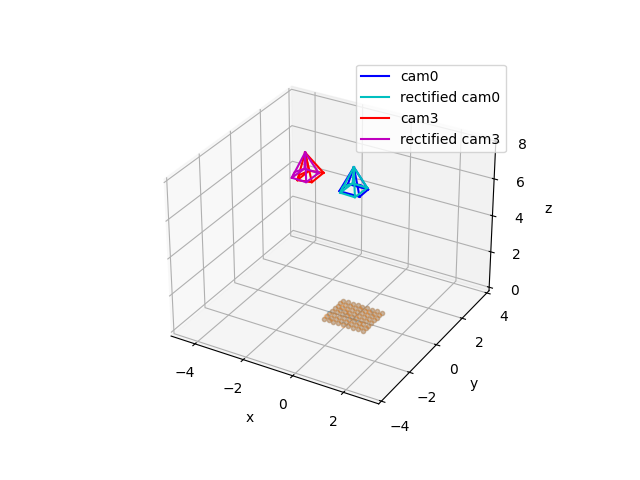

In [3]:
# magnification factor of rectified images
SCALE=2

for c1, c2 in [[0, 1], [0, 2], [0, 3]]:
    img1 = IMG[c1]
    img2 = IMG[c2]

    stereo_pair = pycalib.StereoPair(K[c1], None, img1.shape[1::-1], R_w2c[c1], t_w2c[c1],
                                     K[c2], None, img2.shape[1::-1], R_w2c[c2], t_w2c[c2],
                                     scale=SCALE)
    img1r = stereo_pair.rectify_img_1(img1)
    img2r = stereo_pair.rectify_img_2(img2)
    show_imgs([img1, img2, img1r, img2r], [f'cam{c1}\n{img1.shape[1::-1]}', f'cam{c2}\n{img2.shape[1::-1]}', f'cam{c1}r\n{img1r.shape[1::-1]}', f'cam{c2}r\n{img2r.shape[1::-1]}'], title=f'is_horizontal: {stereo_pair.is_horizontal}')
    show_overlay(img1r, img2r)
    # using chess corners in rectified images as sparse corresponding points
    corners1, img1rc = findchess(img1r)
    corners2, img2rc = findchess(img2r)
    #show_imgs([img1rc, img2rc], [f'cam{c1}rc', f'cam{c2}rc'], title='Corresponding points in rectified images')

    # test rectify_pts2d & unrectify_pts2d
    if True:
        # rectify corners found in the unrectified images to the rectified image coordinates
        c1r = stereo_pair.rectify_pts2d_1(CORNERS_2D[c1])
        c2r = stereo_pair.rectify_pts2d_2(CORNERS_2D[c2])
        assert np.allclose(corners1, c1r, atol=SCALE*2), 'rectify(detection in unrectified img) != detection in rectified img'
        assert np.allclose(corners2, c2r, atol=SCALE*2), 'rectify(detection in unrectified img) != detection in rectified img'
        # # draw on the rectified images
        # i1 = cv2.drawChessboardCorners(img1r.copy(), (8,9), c1r[:,None,:2].astype(np.float32), True)
        # i2 = cv2.drawChessboardCorners(img2r.copy(), (8,9), c2r[:,None,:2].astype(np.float32), True)
        # show_imgs([i1, i2], [f'cam{c1}', f'cam{c2}'], title='Corners found in unrectified image drawn on rectified image')

        # rectified -> unrectified
        c1u = stereo_pair.unrectify_pts2d_1(corners1)
        c2u = stereo_pair.unrectify_pts2d_2(corners2)
        assert np.allclose(CORNERS_2D[c1], c1u, atol=2), 'unrectify(detection in rectified img) != detection in unrectified img'
        assert np.allclose(CORNERS_2D[c2], c2u, atol=2), 'unrectify(detection in rectified img) != detection in unrectified img'
        # # draw on the unrectified images
        # i1 = cv2.drawChessboardCorners(img1.copy(), (8,9), c1u[:,None,:2].astype(np.float32), True)
        # i2 = cv2.drawChessboardCorners(img2.copy(), (8,9), c2u[:,None,:2].astype(np.float32), True)
        # show_imgs([i1, i2], [f'cam{c1}', f'cam{c2}'], title='Corners found in rectified image drawn on unrectified image')


    # verify that we can triangulate 3D points in WCS directly from corresponding points in the rectified images
    X = stereo_pair.triangulate_pts(corners1, corners2)
    assert np.allclose(X, CORNERS_3D, atol=0.1), 'wrong triangulation from corresponding points'
    stereo_pair.plot3d([X, CORNERS_3D], scale=0.4, cam1_name=f'cam{c1}', cam2_name=f'cam{c2}')

    # verify that the corresponding points are on the same horizontal / vertical line (up to a few pixel error)
    disparity = corners1 - corners2
    if stereo_pair.is_horizontal:
        assert np.allclose(disparity[:,1], 0, atol=3*SCALE), 'non-zero vertical disparity in horizontal stereo'
        disparity = disparity[:,0]
    else:
        assert np.allclose(disparity[:,0], 0, atol=3*SCALE), 'non-zero horizontal disparity in vertical stereo'
        disparity = disparity[:,1]

    # disparity map (invalid pixels should have nan) in the first camera
    dmap = np.full(img1rc.shape[:2], np.nan, dtype=np.float32)
    dmap[corners1[:,1].astype(int), corners1[:,0].astype(int)] = disparity
    # triangulate in WCS
    X, mask = stereo_pair.triangulate_dmap(dmap)
    # extract where we originally have corresponding points
    X = X[corners1[:,1].astype(int), corners1[:,0].astype(int)]
    # mask to reject points with zero disparity as they become points at infinity
    valid_pixels = mask[corners1[:,1].astype(int), corners1[:,0].astype(int)]
    # verify that the points are identical to the GT (except for zero-disparity points)
    assert np.allclose(X[valid_pixels], CORNERS_3D[valid_pixels], atol=0.1), 'wrong triangulation from disparity map'

